In [2]:
## tensorflow-gpu==2.3.0 bug to load_weight after call inference
!pip install tensorflow-gpu==2.2.0

In [3]:
import yaml
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow_tts.inference import AutoConfig
from tensorflow_tts.inference import TFAutoModel

In [4]:
config = AutoConfig.from_pretrained("../examples/multiband_melgan/conf/multiband_melgan.v1.yaml")
mb_melgan = TFAutoModel.from_pretrained(
    config=config, 
    pretrained_path=None, # "../examples/fastspeech2/checkpoints/model-150000.h5",
    is_build=False, # don't build model if you want to save it to pb. (TF related bug)
    name="mb_melgan"
)

In [5]:
fake_mels = tf.random.uniform(shape=[4, 256, 80], dtype=tf.float32)

In [6]:
audios = mb_melgan.inference(fake_mels)

In [7]:
mb_melgan.load_weights("../examples/multiband_melgan/checkpoints/mb_melgan.v1-940K.h5")

# Save to Pb

In [8]:
tf.saved_model.save(mb_melgan, "./mb_melgan", signatures=mb_melgan.inference)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./mb_melgan/assets


# Load and Inference

In [9]:
mb_melgan = tf.saved_model.load("./mb_melgan")

In [8]:
mels = np.load("../dump/valid/norm-feats/LJ001-0009-norm-feats.npy")

In [9]:
audios = mb_melgan.inference(mels[None, ...])

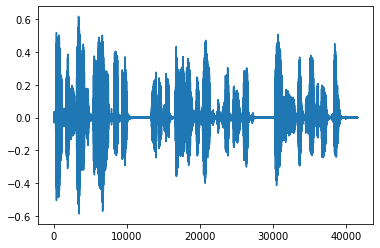

In [10]:
plt.plot(audios[0, :, 0])